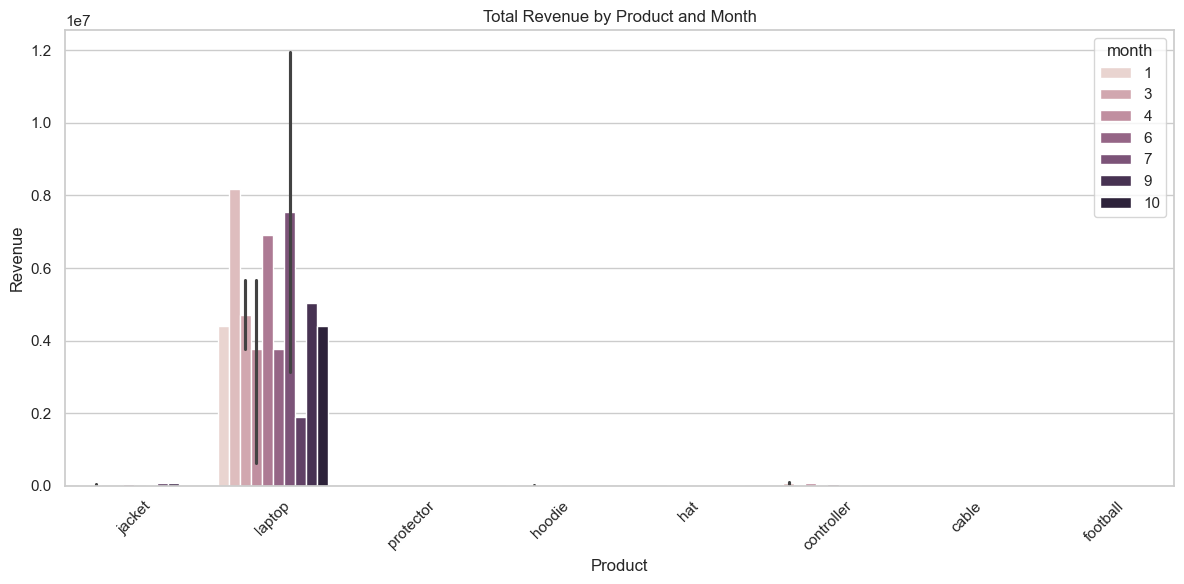

🔝 Top Products by Total Revenue:
product_name
laptop        7.045241e+07
jacket        4.895932e+05
controller    3.721197e+05
hat           1.727577e+05
hoodie        8.255574e+04
football      1.330245e+04
protector     1.246253e+04
cable         1.036035e+04
Name: total_revenue, dtype: float64

📈 Peak Month per Product:
  product_name  month  total_revenue
0        cable      2   4.662158e+03
1   controller      2   1.425139e+05
2     football      3   3.521236e+03
3          hat      7   4.644025e+04
4       hoodie      5   1.681691e+04
5       jacket      9   1.617005e+05
6       laptop      7   1.509694e+07
7    protector      8   5.836883e+03

🌍 Revenue by Region for Top 3 Products:
  product_name region  total_revenue
0   controller   East   1.108442e+05
1   controller  North   1.504314e+05
2   controller  South   1.108442e+05
3       jacket   East   1.437338e+05
4       jacket  North   1.617005e+05
5       jacket  South   1.212754e+05
6       jacket   West   6.288353e+04
7    

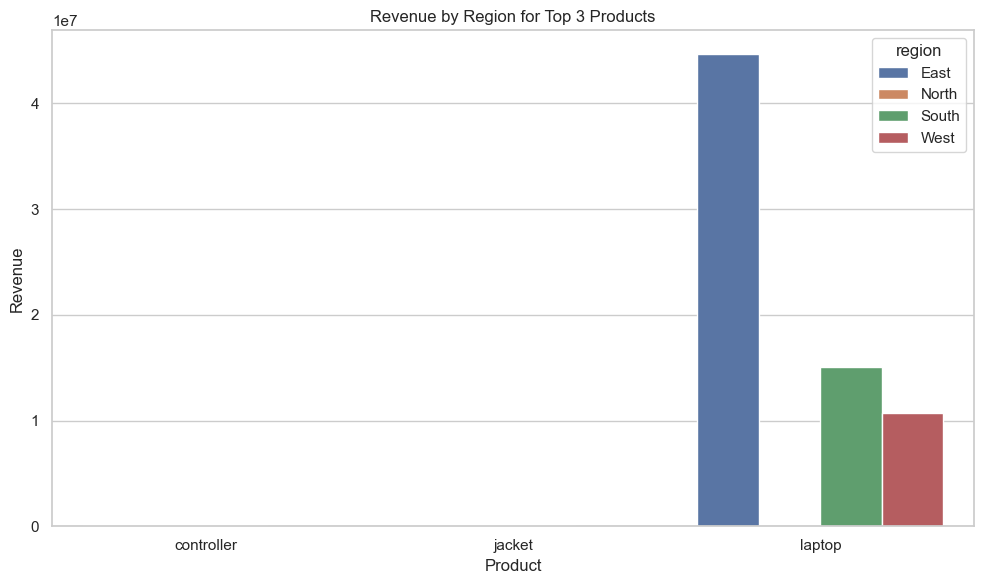

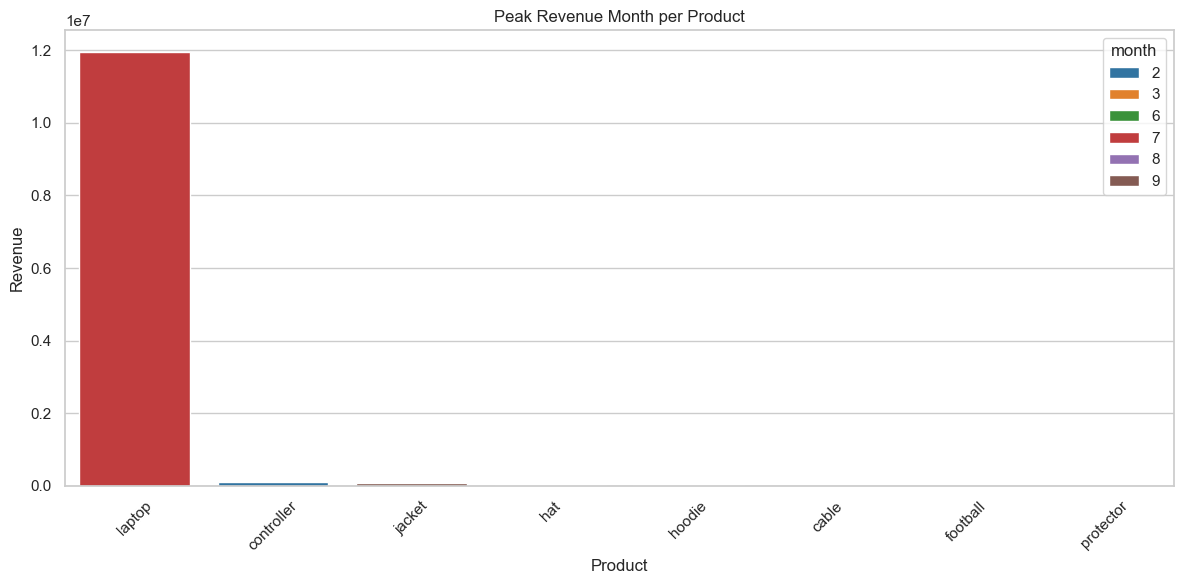

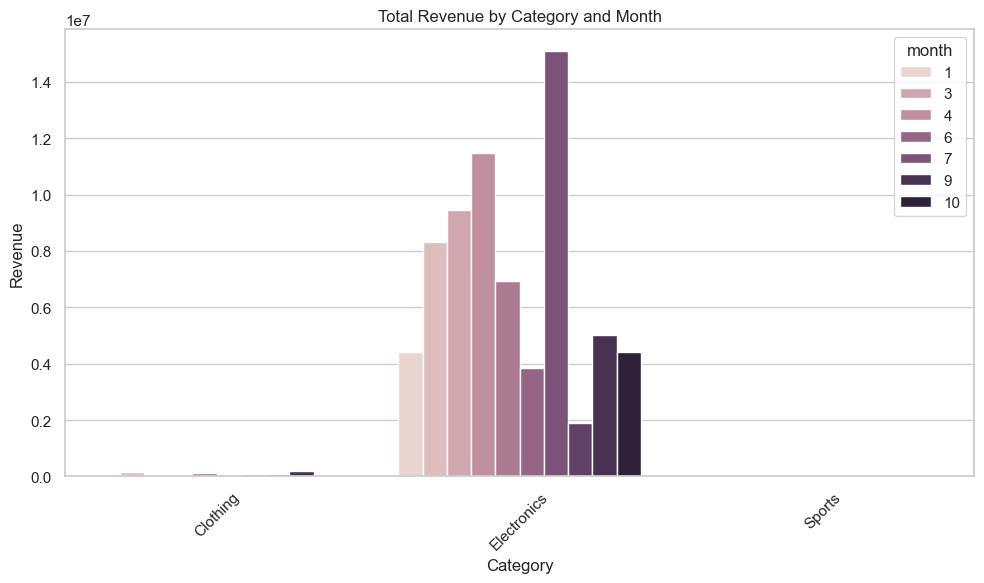

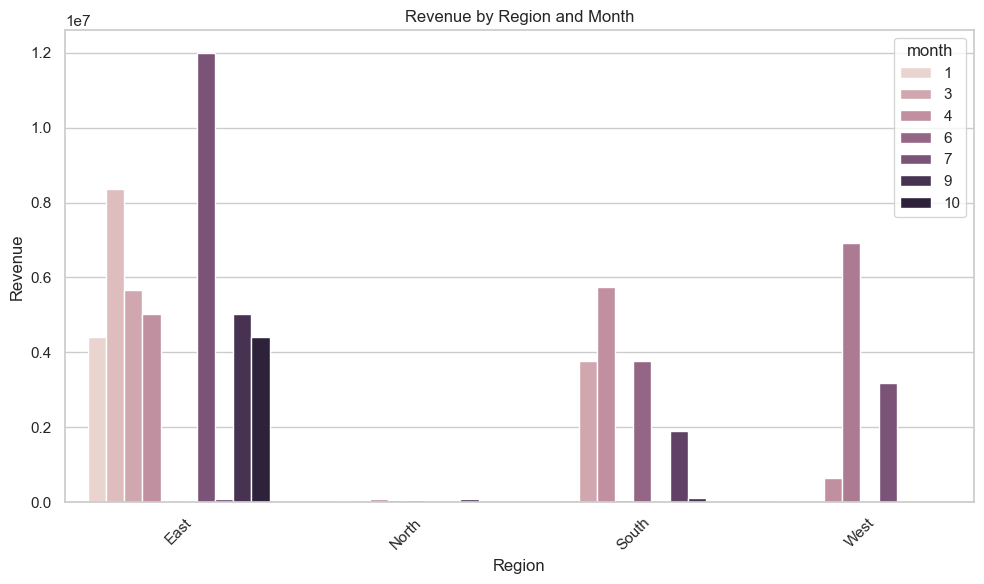

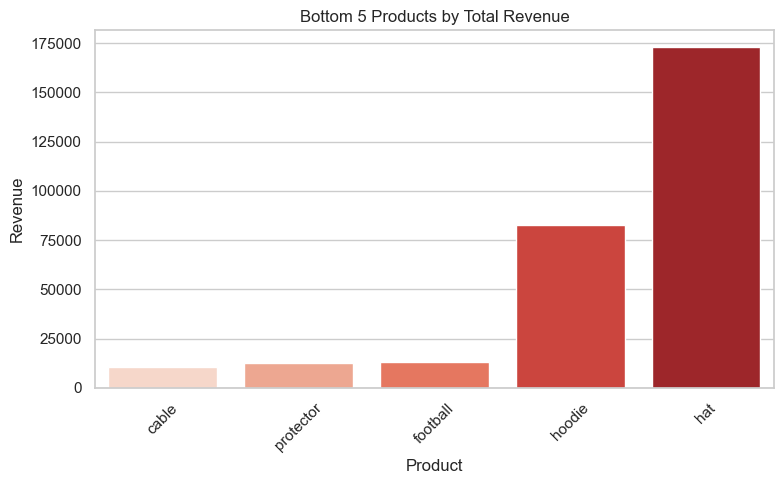

root
 |-- product_name: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- total_profit: double (nullable = true)



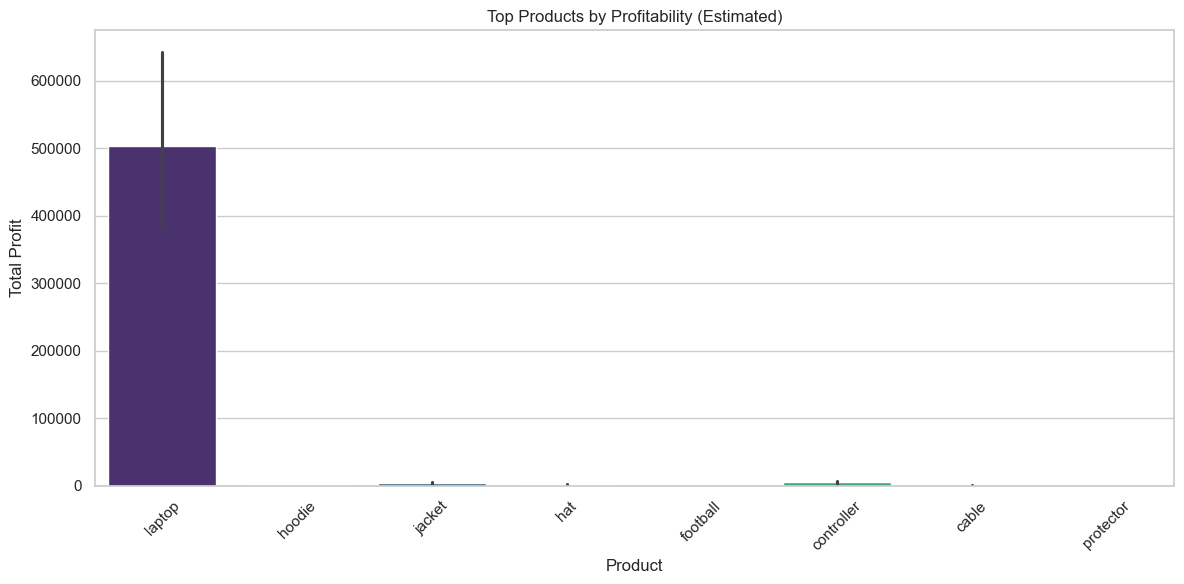

  product_name  month region  total_profit  rank
0       laptop      1   East  440327.53408     1
1       hoodie      1  North     611.52400     1
2       hoodie      1  South     764.40500     1
3       jacket      1   West    2245.84020     1
4       laptop      2   East  817751.13472     1


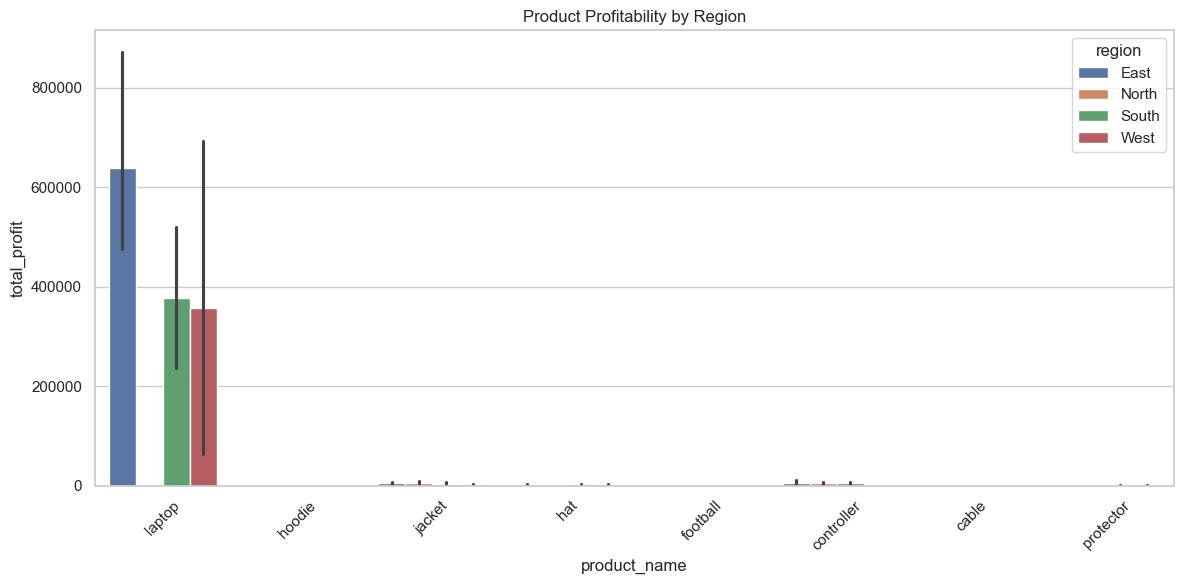

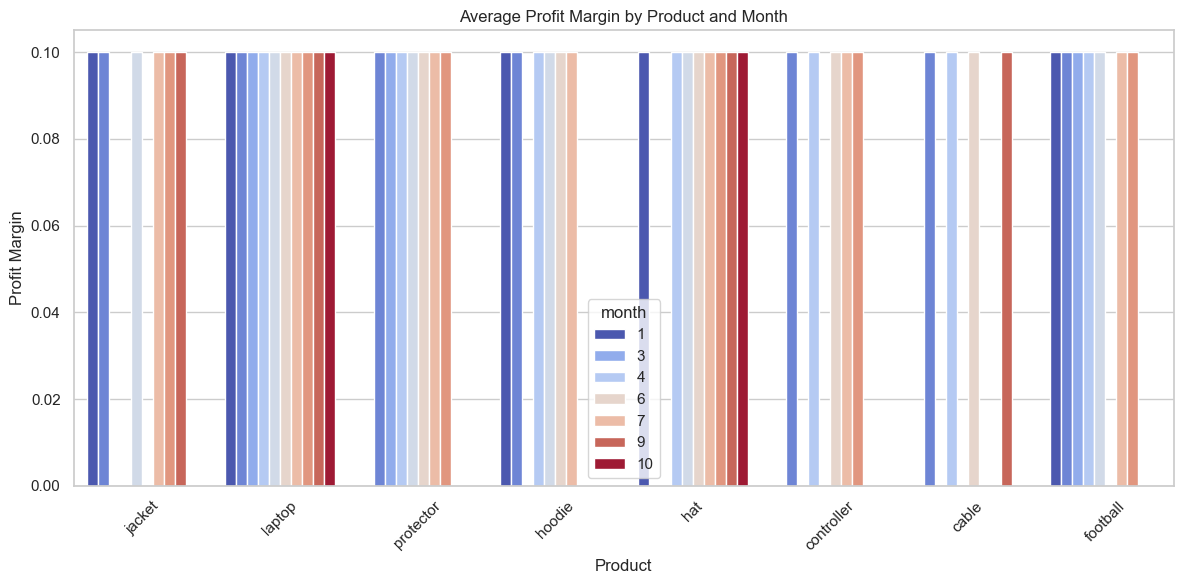

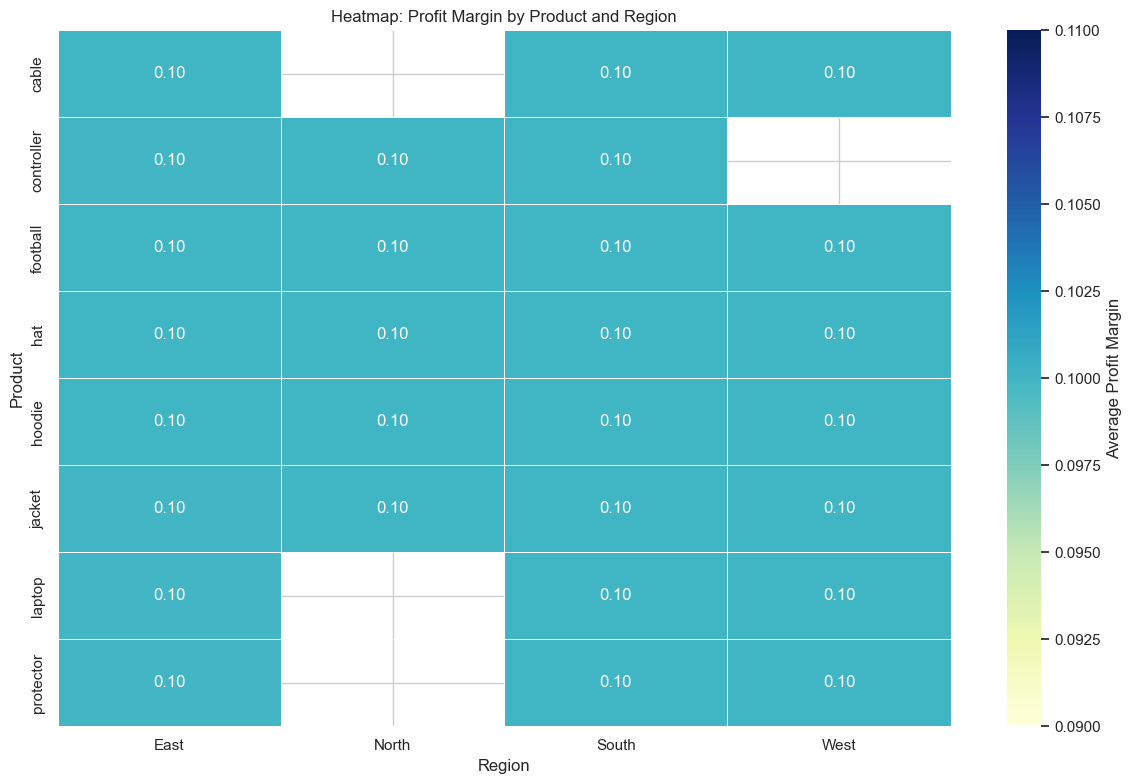

  customer_segment  total_revenue  total_profit  avg_profit_per_customer
0       High Value      1179953.2     117995.32              3806.300645
1        Low Value       115583.6      11558.36               608.334737
2        Mid Value       875590.0      87559.00              1989.977273


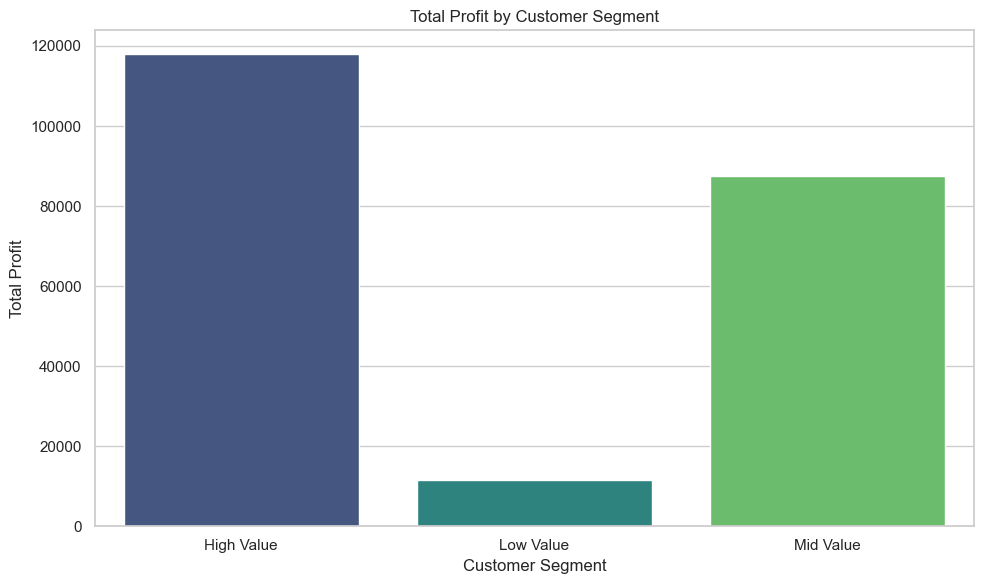

In [72]:
# scripts/module7_bi_project.py

import findspark
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import os

# Constants
PROFIT_MARGIN = 0.10  # Estimated profit margin (10%)

# Initialize Spark session
findspark.init()
spark = SparkSession.builder \
    .appName("Module7 BI Project") \
    .config("spark.jars", "lib/sqlite-jdbc-3.49.1.0.jar") \
    .getOrCreate()

# Load data from SQLite
db_url = "jdbc:sqlite:data/dw/smart_sales.db"

df_sales = spark.read.format("jdbc").option("url", db_url).option("dbtable", "sale").option("driver", "org.sqlite.JDBC").load()
df_products = spark.read.format("jdbc").option("url", db_url).option("dbtable", "product").option("driver", "org.sqlite.JDBC").load()
df_customer = spark.read.format("jdbc").option("url", db_url).option("dbtable", "customer").option("driver", "org.sqlite.JDBC").load()

#  Join and transform data
df_sales.createOrReplaceTempView("sale")
df_products.createOrReplaceTempView("product")
df_customer.createOrReplaceTempView("customer")

df_full = spark.sql("""
SELECT s.*, p.product_name, p.category, p.unit_price, c.region
FROM sale s
JOIN product p ON s.product_id = p.product_id
JOIN customer c ON s.customer_id = c.customer_id
""")

df_full = df_full.withColumn("sale_date_parsed", F.to_date("sale_date", "M/d/yyyy")) \
    .withColumn("month", F.month("sale_date_parsed")) \
    .withColumn("year", F.year("sale_date_parsed")) \
    .withColumn("revenue", F.col("sale_amount") * F.col("unit_price")) \
    .withColumn("profitability", F.col("revenue") * F.lit(PROFIT_MARGIN))  # Estimated profit

#  Aggregation
df_aggregated = df_full.groupBy("product_name", "month", "region").agg(
    F.sum("sale_amount").alias("total_sales_volume"),
    F.avg("unit_price").alias("average_unit_price"),
    F.sum("revenue").alias("total_revenue")
)


df_pd = df_aggregated.toPandas()


if not os.path.exists("visuals"):
    os.makedirs("visuals")

# Visualization - Revenue by product and month
plt.figure(figsize=(12, 6))
sns.barplot(data=df_pd, x="product_name", y="total_revenue", hue="month")
plt.xticks(rotation=45)
plt.title("Total Revenue by Product and Month")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig("visuals/revenue_by_product_month.png")
plt.show()

# Insights
top_products = df_pd.groupby("product_name")["total_revenue"].sum().sort_values(ascending=False)
print("🔝 Top Products by Total Revenue:")
print(top_products)

peak_months = df_pd.groupby(["product_name", "month"])["total_revenue"].sum().reset_index()
peak_months = peak_months.sort_values(["product_name", "total_revenue"], ascending=[True, False])
peak_months = peak_months.groupby("product_name").first().reset_index()
print("\n📈 Peak Month per Product:")
print(peak_months)

top3_products = top_products.head(3).index.tolist()
top3_data = df_pd[df_pd["product_name"].isin(top3_products)]

revenue_by_region = top3_data.groupby(["product_name", "region"])["total_revenue"].sum().reset_index()
print("\n🌍 Revenue by Region for Top 3 Products:")
print(revenue_by_region)

plt.figure(figsize=(10, 6))
sns.barplot(data=revenue_by_region, x="product_name", y="total_revenue", hue="region")
plt.title("Revenue by Region for Top 3 Products")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig("visuals/revenue_by_region_top3.png")
plt.show()

# Peak revenue month per product
peak_month_df = df_pd.sort_values("total_revenue", ascending=False).groupby("product_name").first().reset_index()
peak_month_df = peak_month_df.sort_values("total_revenue", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=peak_month_df, x="product_name", y="total_revenue", hue="month", palette="tab10")
plt.xticks(rotation=45)
plt.title("Peak Revenue Month per Product")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig("visuals/peak_revenue_month_per_product.png")
plt.show()

# Revenue by category and month
df_category_revenue = df_full.groupBy("category", "month").agg(
    F.sum("revenue").alias("total_revenue")
).orderBy("category", "month")

df_cat_pd = df_category_revenue.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_cat_pd, x="category", y="total_revenue", hue="month")
plt.title("Total Revenue by Category and Month")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("visuals/revenue_by_category_month.png")
plt.show()

# Revenue by region and month
df_region_revenue = df_full.groupBy("region", "month").agg(
    F.sum("revenue").alias("total_revenue")
).orderBy("region", "month")

df_reg_pd = df_region_revenue.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_reg_pd, x="region", y="total_revenue", hue="month")
plt.title("Revenue by Region and Month")
plt.xlabel("Region")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("visuals/revenue_by_region_month.png")
plt.show()

# Bottom 5 products by total revenue
df_low_perf = df_full.groupBy("product_name").agg(
    F.sum("revenue").alias("total_revenue")
).orderBy("total_revenue").limit(5)

df_low_pd = df_low_perf.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=df_low_pd, x="product_name", y="total_revenue", hue="product_name", palette="Reds", legend=False)
plt.title("Bottom 5 Products by Total Revenue")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("visuals/low_performing_products.png")
plt.show()

# Profitability ranking (using estimated margin)
df_ranked = df_full.groupBy("product_name", "month", "region").agg(
    F.sum("profitability").alias("total_profit")
)

df_ranked.printSchema() 

# Rank products by profitability per month and region
window_spec = Window.partitionBy("month", "region").orderBy(F.desc("total_profit"))
df_ranked = df_ranked.withColumn("rank", F.rank().over(window_spec))

# Convert to Pandas and visualize
df_ranked_pd = df_ranked.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_ranked_pd, x="product_name", y="total_profit", hue="product_name", palette="viridis", legend=False)
plt.xticks(rotation=45)
plt.title("Top Products by Profitability (Estimated)")
plt.xlabel("Product")
plt.ylabel("Total Profit")
plt.tight_layout()
plt.savefig("visuals/top_products_by_profitability.png")
plt.show()

df_top_ranked = df_ranked.filter(F.col("rank") == 1)
df_top_ranked_pd = df_top_ranked.toPandas()
print(df_top_ranked_pd.head())

plt.figure(figsize=(12, 6))
sns.barplot(data=df_ranked_pd, x="product_name", y="total_profit", hue="region")
plt.title("Product Profitability by Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Adding profit margin to the dataframe
df_full_with_margin = df_full.withColumn("profit_margin", F.col("profitability") / F.col("revenue"))

# Aggregating profit margin by product, month, and region
df_margin_analysis = df_full_with_margin.groupBy("product_name", "month", "region").agg(
    F.avg("profit_margin").alias("average_profit_margin")
)

# Convert to Pandas for easier plotting
df_margin_analysis_pd = df_margin_analysis.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_margin_analysis_pd, x="product_name", y="average_profit_margin", hue="month", palette="coolwarm")
plt.title("Average Profit Margin by Product and Month")
plt.xlabel("Product")
plt.ylabel("Profit Margin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("visuals/profit_margin_by_product_month.png")
plt.show() 

# Calculate the average profit margin by product and region
df_margin_analysis_heatmap = df_full_with_margin.groupBy("product_name", "region").agg(
    F.avg("profit_margin").alias("avg_profit_margin")
)

# Convert to Pandas for easier plotting
df_margin_analysis_heatmap_pd = df_margin_analysis_heatmap.toPandas()

# Pivot the data for heatmap: rows are products, columns are regions
pivot_df = df_margin_analysis_heatmap_pd.pivot(index="product_name", columns="region", values="avg_profit_margin")


# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", linewidths=0.5, fmt=".2f", cbar_kws={'label': 'Average Profit Margin'})
plt.title("Heatmap: Profit Margin by Product and Region")
plt.xlabel("Region")
plt.ylabel("Product")
plt.tight_layout()
plt.savefig("visuals/profit_margin_heatmap.png")
plt.show()

# Calculate revenue per customer
customer_revenue = df_combined.groupby("customerid").agg(
    total_revenue=("revenue", "sum")
).reset_index()

# Define segments using quantiles
q1 = customer_revenue["total_revenue"].quantile(0.25)
q3 = customer_revenue["total_revenue"].quantile(0.75)

def assign_segment(revenue):
    if revenue >= q3:
        return "High Value"
    elif revenue <= q1:
        return "Low Value"
    else:
        return "Mid Value"

customer_revenue["customer_segment"] = customer_revenue["total_revenue"].apply(assign_segment)



df_combined = df_combined.drop(columns=["customer_segment"], errors="ignore")

#  Merge segments
df_combined = df_combined.merge(
    customer_revenue[["customerid", "customer_segment"]],
    on="customerid",
    how="left"
)

#  Aggregate metrics
df_customer_segment = df_combined.groupby("customer_segment").agg(
    total_revenue=("revenue", "sum"),
    total_profit=("profitability", "sum"),
    avg_profit_per_customer=("profitability", "mean")
).reset_index()

print(df_customer_segment)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Customer segmentation data
data = {
    'customer_segment': ['High Value', 'Low Value', 'Mid Value'],
    'total_revenue': [1179953.2, 115583.6, 875590.0],
    'total_profit': [117995.32, 11558.36, 87559.00],
    'avg_profit_per_customer': [3806.300645, 608.334737, 1989.977273]
}

df_customer_segment = pd.DataFrame(data)


# Create the bar chart for total profit by customer segment
plt.figure(figsize=(10, 6))
sns.barplot(data=df_customer_segment, x="customer_segment", y="total_profit", hue="customer_segment", palette="viridis", legend=False)
plt.title("Total Profit by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Profit")
plt.tight_layout()

# Save the figure to the visuals folder
plt.savefig("visuals/customer_segment_profit.png")

# Show the plot
plt.show()











